**Solution on Basic Classification Models**

BAS 474

Charles Liu

In [ ]:
library(regclass)
library(caret)
library(pROC)

# AUC

The AUC (area under the ROC curve) is often used in business analytics to gauge the utility of a model because it tells us how well the model ranks probabilities.  If a company needs to select the "500 customers most likely to ...", then the higher the value of AUC, the better the model will be at coming up with a list.  

The numerical value of the AUC can be interpreted as follows.  If a random member of the "Yes" class is selected along with a random member of the "No" class, and the model scores both of them, the AUC tells us the probability that the model would give a higher score to the member of the Yes class.

In this problem you will write a function called `pairwise_auc` which takes two arguments:  `actual` (a vector of class labels) and `predicted` (a vector of scores or probabilities given by a model); no default values of the arguments.  

Your function will systematically consider each pair of individuals (with one being from the "Yes" class and the other being from the "No" class) and find the fraction of pairs whose scores/probabilities are ranked correctly.  This fraction gives a good approximation to the AUC.

As with all functions, it's best to build this up in pieces.  Let's work with the following definitions of `actual` and `predicted`.

In [2]:
set.seed(474); actual <- sample( factor( rep( c("Yes","No"), 8) ) )  #actual classes
actual
set.seed(474); predicted <- round( runif(16,1,100), digits=4 ) #random numbers between 1 and 100
predicted

[1] No  Yes No  Yes Yes Yes No  Yes No  No  Yes Yes No  Yes No  No 
Levels: No Yes

[1] 33.2275 68.8393 49.6622 29.7502 38.7359 92.8548 41.8691 52.6923  5.0535
[10] 70.1193 10.0717 32.7867 38.9003 60.7294 28.2518 53.5663

a)  Make a dataframe called `VALUES` whose first column contains the elements of `actual` and whose second column contains the elements of `predicted` (the columns should be named "actual" and "predicted", respectively).  Include the results of running `head`.

In [3]:
VALUES <- data.frame(actual,predicted)
head(VALUES,3)

,actual,predicted
,<fct>,<dbl>
1,No,33.2275
2,Yes,68.8393
3,No,49.6622


b)  Make two new dataframes:  `YES` and `NO` which contain the rows in `VALUES` corresponding to "Yes" class and which contain the rows in `VALUES` corresponding to the "No" class, respectively.  Include the output of the two `head` commands.

In [4]:
YES <- subset(VALUES, actual=="Yes")
NO <- subset(VALUES, actual!="Yes")
head(YES,3)
head(NO,3)

,actual,predicted
,<fct>,<dbl>
2,Yes,68.8393
4,Yes,29.7502
5,Yes,38.7359


,actual,predicted
,<fct>,<dbl>
1,No,33.2275
3,No,49.6622
7,No,41.8691


c)  Consider the score in the first row of `YES`.  By taking the `mean` of a logical condition, find the fraction of scores in `NO` that are smaller than this score and left-arrow it into a variable called `p.correctrank`.  Print the contents of `p.correctrank` to the screen.

In [5]:
p.correctrank <- mean( YES$predicted[1] > NO$predicted )
p.correctrank

[1] 0.875

d)  Now write a `for` loop that does this for each score in `YES`.  In other words, define `p.correctrank` to be an empty vector, then write a `for` loop that defines the first element of `p.correctrank` to be the fraction of scores in `NO` that are smaller than the score in the first row of `YES`, defines the second element of `p.correctrank` to be the fraction of scores in `NO` that are smaller than the score in the second row of `YES`, etc.   Print out the 8 elements of `p.correctrank` to the screen.

In [6]:
p.correctrank <- c()
for (i in 1:nrow(YES)) {
  p.correctrank[i] <- mean( YES$predicted[i] > NO$predicted )
}
p.correctrank

[1] 0.875 0.250 0.375 1.000 0.750 0.125 0.250 0.875

e)  Left-arrow into `AUC` the average of the values in `p.correctrank`.  The average of this vector gives the overall fraction of pairs of individuals who scores are ranked correctly, so it gives a good approximation to the AUC.

In [7]:
AUC <- mean(p.correctrank)
AUC

[1] 0.5625

f)  Now modify your code so that it works inside the function  `pairwise_auc`.  Remember that the two arguments will be the vectors `actual` and `predicted` (you can assume that `actual` will always contain "Yes" and "No" and `predicted` will be a vector of numbers).  Make sure you `return` the value of the AUC!  

Test your function on the vectors `scores.for.individuals` and `actual.classes` defined by the code below (probabilities/classes for wine quality).  You should find an answer close to 0.858.  Note:  the `roc` function we have been using to calculate the areas under the ROC curve proceeds in a different way to estimate the AUC, so its value can be quite different (as it is for this example).

In [8]:
pairwise_auc <- function(actual, predicted, positive='Yes') {
  VALUES <- data.frame(actual,predicted)
  YES <- subset(VALUES,actual==positive)
  NO <- subset(VALUES,actual!=positive)
  p.correctrank <- c()
  for (i in 1:nrow(YES)) {
    p.correctrank[i] <- mean( YES$predicted[i] > NO$predicted )
  }
  AUC <- mean(p.correctrank)
  return(AUC)
}

data(WINE)
set.seed(474)
MODEL <- train(Quality~.,data=WINE,method="glm",
              trControl=trainControl(method="none",classProbs=TRUE))
predicted <- predict(MODEL,newdata=WINE,type="prob")[,'high']
pairwise_auc(WINE$Quality, predicted, 'high')

#AUC estimated by `roc` uses a slightly different procedure
roc(WINE$Quality, predicted, levels = c('low', 'high'))

[1] 0.8967263

Setting direction: controls < cases




Call:
roc.default(response = WINE$Quality, predictor = predicted, levels = c("low",     "high"))

Data: predicted in 1640 controls (WINE$Quality low) < 1060 cases (WINE$Quality high).
Area under the curve: 0.8967

# Basic Classification

This part is from the lecture slides, with minor changes. Please read the slides for background introduction and follow the instructions here to answer the questions.

a) First we will load the data set.

In [9]:
data(PIMA)
dim(PIMA)

[1] 392   8

b) Using 80% of the data for modeling and 20% for holdout validation, please creat the TRAIN and HODOUT data sets.

In [10]:
set.seed(747)
train.rows <- sample(1:nrow(PIMA), 0.8*nrow(PIMA))
TRAIN <- PIMA[train.rows,]
HOLDOUT <- PIMA[-train.rows,]

mean(TRAIN$Diabetes=='Yes')
mean(HOLDOUT$Diabetes=='Yes')

[1] 0.3290735

[1] 0.3417722

c) Using 3-fold cross validation, please report the accuracy of the cross-validation to predict the variable `Diabetes`.

In [11]:
set.seed(474)
fitControl <- trainControl(method="cv",number=3, classProbs=TRUE)
MODEL <- train(Diabetes~.,data=TRAIN, method="glm", trControl=fitControl)
summary(MODEL)
MODEL$results


Call:
NULL

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0550  -0.6550  -0.3553   0.6741   2.5182  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -9.818700   1.320785  -7.434 1.05e-13 ***
Pregnant       0.102444   0.059539   1.721   0.0853 .  
Glucose        0.041037   0.006548   6.267 3.68e-10 ***
BloodPressure  0.001041   0.013491   0.077   0.9385    
BodyFat        0.026565   0.019192   1.384   0.1663    
Insulin       -0.001046   0.001430  -0.731   0.4647    
BMI            0.054946   0.030425   1.806   0.0709 .  
Age            0.025737   0.019549   1.317   0.1880    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 396.58  on 312  degrees of freedom
Residual deviance: 274.79  on 305  degrees of freedom
AIC: 290.79

Number of Fisher Scoring iterations: 5


,parameter,Accuracy,Kappa,AccuracySD,KappaSD
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,none,0.7731685,0.459729,0.02408564,0.06948415


d) Repeat the cross-validation but plot the roc curve and report its auc.

In [12]:
set.seed(474)
fitControl <- trainControl(method="cv",number=3, classProbs=TRUE, summaryFunction=twoClassSummary)
MODEL <- train(Diabetes~.,data=TRAIN, method="glm", trControl=fitControl)
summary(MODEL)
MODEL$results

Warning message in train.default(x, y, weights = w, ...):
“The metric "Accuracy" was not in the result set. ROC will be used instead.”



Call:
NULL

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0550  -0.6550  -0.3553   0.6741   2.5182  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -9.818700   1.320785  -7.434 1.05e-13 ***
Pregnant       0.102444   0.059539   1.721   0.0853 .  
Glucose        0.041037   0.006548   6.267 3.68e-10 ***
BloodPressure  0.001041   0.013491   0.077   0.9385    
BodyFat        0.026565   0.019192   1.384   0.1663    
Insulin       -0.001046   0.001430  -0.731   0.4647    
BMI            0.054946   0.030425   1.806   0.0709 .  
Age            0.025737   0.019549   1.317   0.1880    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 396.58  on 312  degrees of freedom
Residual deviance: 274.79  on 305  degrees of freedom
AIC: 290.79

Number of Fisher Scoring iterations: 5


,parameter,ROC,Sens,Spec,ROCSD,SensSD,SpecSD
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,none,0.8412805,0.8761905,0.5627451,0.02599561,0.01649572,0.08029645


To plot the roc curve on the training data:

Setting levels: control = No, case = Yes

Setting direction: controls < cases



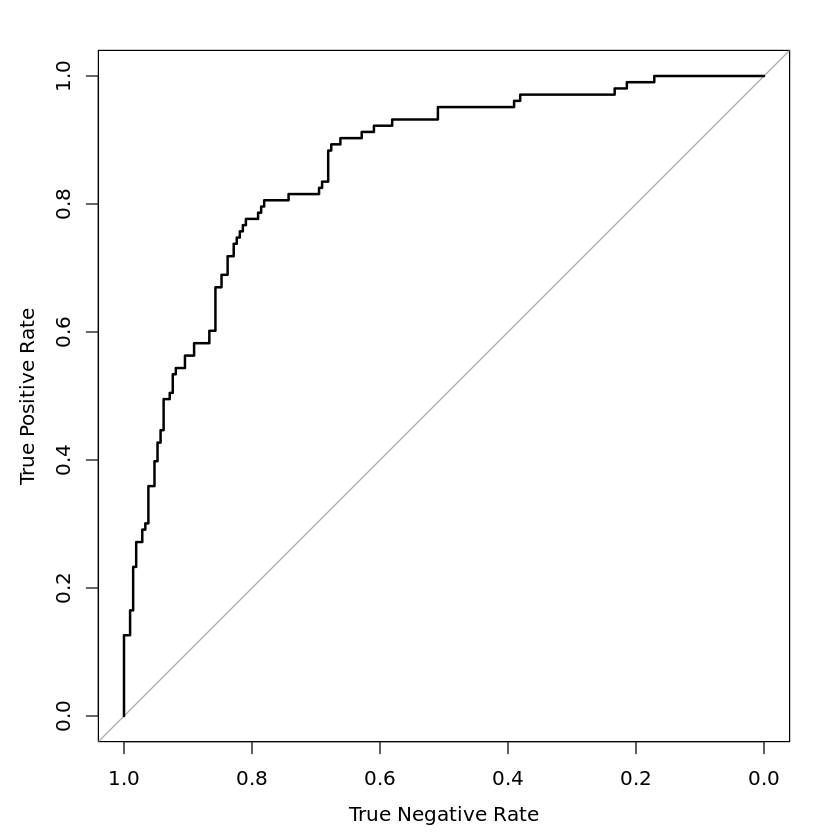

In [13]:
ACTUAL <- TRAIN$Diabetes
PROB <- predict(MODEL, newdata=TRAIN, type="prob")$Yes
roc.train <- roc(ACTUAL, PROB)
plot( roc.train, xlab="True Negative Rate", ylab="True Positive Rate", xlim=c(1,0), ylim=c(0,1) )

e) Please report the holdout performance of the model in terms of accuracy and auc.

In [14]:
ACTUAL <- HOLDOUT$Diabetes
PROBS <- predict(MODEL, newdata=HOLDOUT, type="prob")
PREDICTIONS <- as.factor(names(PROBS)[max.col(PROBS)])
confusionMatrix(PREDICTIONS, ACTUAL, positive='Yes')
postResample(PREDICTIONS, ACTUAL)
roc(ACTUAL, PROBS$Yes)

Confusion Matrix and Statistics

          Reference
Prediction No Yes
       No  48  15
       Yes  4  12
                                          
               Accuracy : 0.7595          
                 95% CI : (0.6502, 0.8486)
    No Information Rate : 0.6582          
    P-Value [Acc > NIR] : 0.03491         
                                          
                  Kappa : 0.4074          
                                          
 Mcnemar's Test P-Value : 0.02178         
                                          
            Sensitivity : 0.4444          
            Specificity : 0.9231          
         Pos Pred Value : 0.7500          
         Neg Pred Value : 0.7619          
             Prevalence : 0.3418          
         Detection Rate : 0.1519          
   Detection Prevalence : 0.2025          
      Balanced Accuracy : 0.6838          
                                          
       'Positive' Class : Yes             
                                 

Accuracy     Kappa 
0.7594937 0.4074220

Setting levels: control = No, case = Yes

Setting direction: controls < cases




Call:
roc.default(response = ACTUAL, predictor = PROBS$Yes)

Data: PROBS$Yes in 52 controls (ACTUAL No) < 27 cases (ACTUAL Yes).
Area under the curve: 0.8355